In [4]:
import numpy as np
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from IPython.display import SVG
from graphviz import Source
from IPython.display import display
import matplotlib.pyplot as plt
from interactions import apply_rule, traverse_all_paths, make_line, make_grid
from itertools import combinations_with_replacement

/usr/local/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [13]:
#output: X is a n*2 matrix with values ~ Uniform(x_range)
#y is of the form a * x1^2 + b * x2^2 + c * x1x2 + d * x1 + e * x2 + f, all coefficients specified in array argument
def make_polynomial_data(n, x_range, coeffs):
    X = np.random.uniform(x_range[0], x_range[1], (n, 2))
    x1 = X[:, 0]
    x2 = X[:, 1]
    y = coeffs[0] * x1 * x1 + coeffs[1] * x2 * x2 + coeffs[2] * x1 * x2 + coeffs[3] * x1 + coeffs[4] * x2 + coeffs[5]
    return X, y

In [8]:
def train_tree(X, y, depth_lim = None):
    model = DecisionTreeRegressor(max_depth=depth_lim)
    model.fit(X, y)
    return model

In [17]:
coeffs_simple = [0, 0, 1, 0, 0, 0]
X, y = make_polynomial_data(10000, (0, 10), coeffs_simple)
short_tree = train_tree(X, y, depth_lim=3)
tall_tree = train_tree(X, y)
short_vals = traverse_all_paths(short_tree, X, y, [1, 0], continuous_y=True)
tall_vals = traverse_all_paths(tall_tree, X, y, [1, 0], continuous_y=True)
short_line = make_line(short_vals, (0, 10), .1, 0, 2)
tall_line = make_line(tall_vals, (0, 10), .1, 0, 2)

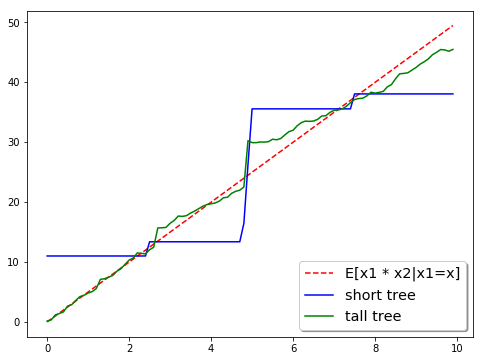

In [19]:
x_axis = np.arange(0, 10, .1)
expectation = x_axis * 5
fig, ax = plt.subplots()
fig.set_size_inches(8, 6, forward=True)
plt.plot(x_axis, expectation, 'k--', c='r', label='E[x1 * x2|x1=x]')
plt.plot(x_axis, short_line, 'k', c='b', label='short tree')
plt.plot(x_axis, tall_line, 'k', c='g', label='tall tree')
legend = ax.legend(loc='lower right', shadow=True, fontsize='x-large')
plt.show()

In [32]:
def random_poly():
    integer_coeffs = np.arange(0, 10)
    coeffs = np.random.choice(integer_coeffs, 6)
    print(coeffs)
    X, y = make_polynomial_data(10000, (0, 10), coeffs)
    short_tree = train_tree(X, y, depth_lim=3)
    tall_tree = train_tree(X, y)
    short_vals = traverse_all_paths(short_tree, X, y, [1, 0], continuous_y=True)
    tall_vals = traverse_all_paths(tall_tree, X, y, [1, 0], continuous_y=True)
    short_line = make_line(short_vals, (0, 10), .1, 0, 2)
    tall_line = make_line(tall_vals, (0, 10), .1, 0, 2)
    x_axis = np.arange(0, 10, .1)
    e_x_squared = (100/12.0) + 25
    expectation = coeffs[0] * x_axis ** 2 + coeffs[1] * e_x_squared + coeffs[2] * 5 * x_axis + coeffs[3] * x_axis + coeffs[4] * 5 + coeffs[5]
    fig, ax = plt.subplots()
    fig.set_size_inches(8, 6, forward=True)
    plt.plot(x_axis, expectation, 'k--', c='r', label='E[f(x1, x2)|x1=x]')
    plt.plot(x_axis, short_line, 'k', c='b', label='short tree')
    plt.plot(x_axis, tall_line, 'k', c='g', label='tall tree')
    legend = ax.legend(loc='lower right', shadow=True, fontsize='x-large')
    plt.show()

[8 0 1 1 0 8]


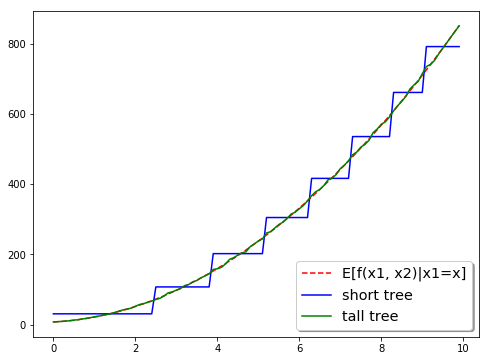

In [41]:
random_poly()

[1 2 3 9 2 0]


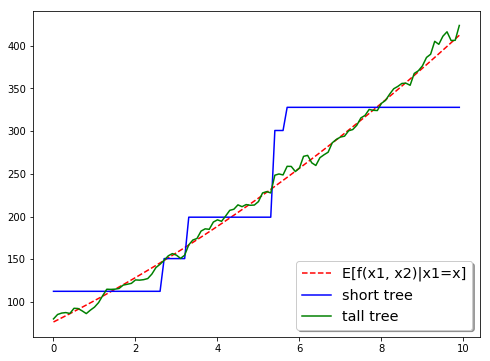

In [36]:
random_poly()

[0 2 8 3 7 7]


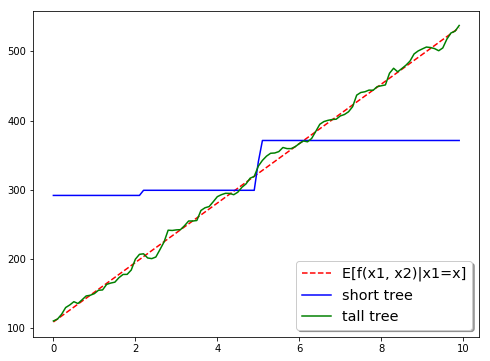

In [40]:
random_poly()

In [4]:
def make_three_var_data(n, x_range, coeffs):
    X = np.random.uniform(x_range[0], x_range[1], (n, 3))
    const = np.ones((n, 1))
    X_const = np.hstack((X, const))
    l = list(combinations_with_replacement(np.transpose(X_const), 2))
    y = np.zeros(n)
    for i in range(len(coeffs)):
        y += coeffs[i] * l[i][0] * l[i][1]
    return X, y

In [19]:
def make_heatmap(vals, label):
    fig, ax = plt.subplots()
    fig.set_size_inches(8, 6, forward=True)
    im = ax.imshow(vals)
    cbar_kw = {}
    cbarlabel = label
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")
    ax.set_xticks(np.arange(100, step=10))
    ax.set_yticks(np.arange(100, step=10))
    ax.set_xticklabels(np.round(np.arange(0, 10, step = 1), 2))
    ax.set_yticklabels(np.round(np.arange(0, 10, step = 1), 2))
    plt.show()

In [6]:
def conditional_exp(x1_range, x2_range, coeffs):
    e_x = 5
    e_x_squared = (100/12.0) + 25
    vals = np.zeros((len(x1_range), len(x2_range)))
    for i in range(vals.shape[0]):
        for j in range(vals.shape[1]):
            x1 = x1_range[i]
            x2 = x2_range[j]
            prods = np.array([x1 * x1, x1 * x2, x1 * e_x, x1, x2 * x2, x2 * e_x, x2, e_x_squared, e_x, 1])
            vals[j, i] = np.sum(prods * coeffs)
    return vals


In [7]:
def specified_poly_3rd_degree(coeffs):
    X, y = make_three_var_data(1000, (0, 10), coeffs)
    print("avg", np.mean(X[:, 2]), "sqrd", np.mean(X[:, 2] ** 2))
    print("y max", max(y), "y min", min(y), "y mean", np.mean(y))
    short_tree = train_tree(X, y, depth_lim=3)
    tall_tree = train_tree(X, y)
    short_vals = traverse_all_paths(short_tree, X, y, [1, 1, 0], continuous_y=True)
    tall_vals = traverse_all_paths(tall_tree, X, y, [1, 1, 0], continuous_y=True)
    short_grid = make_grid(short_vals, (0, 10), (0, 10), .1, 3)
    tall_grid = make_grid(tall_vals, (0, 10), (0, 10), .1, 3)
    x1_range = np.arange(0, 10, .1)
    x2_range = np.arange(0, 10, .1)
    expectation = conditional_exp(x1_range, x2_range, coeffs)
    make_heatmap(short_grid, "short tree scores")
    make_heatmap(tall_grid, "tall tree scores")
    make_heatmap(expectation, "conditional expectation")

avg 5.087706390355828 sqrd 34.06522776830629
y max 2721.254504339077 y min 14.746691585600816 y mean 916.5078888411472


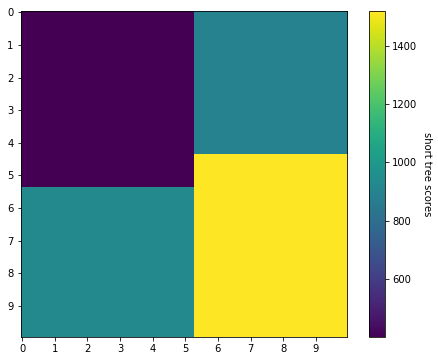

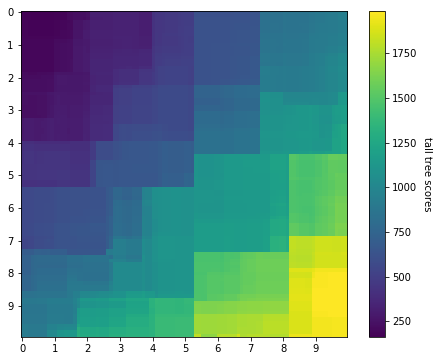

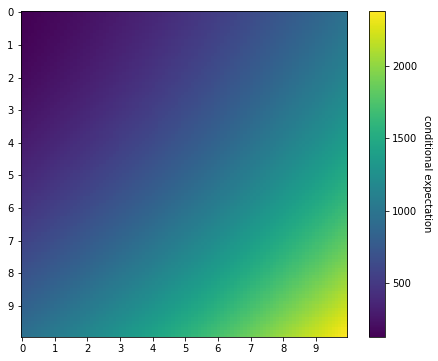

In [10]:
specified_poly_3rd_degree(np.array([4, 6, 8, 5, 7, 2, 5, 3, 4, 5]))

avg 4.891682155179069 sqrd 32.2824837586501
y max 2275.720100073232 y min 10.12314589730209 y mean 732.0374990479207


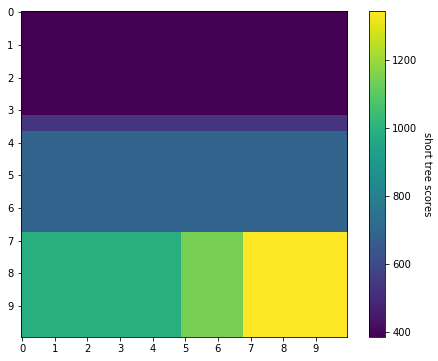

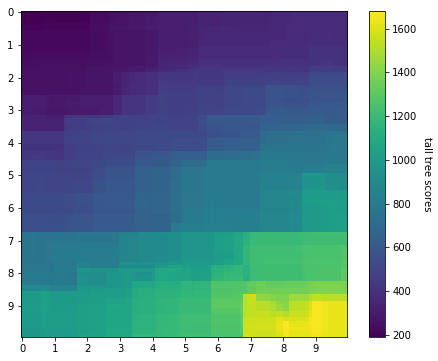

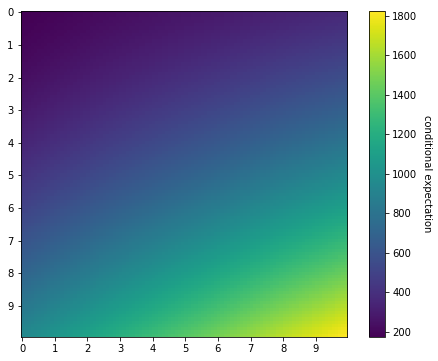

In [11]:
specified_poly_3rd_degree(np.array([0, 7, 2, 9, 6, 3, 4, 5, 1, 3]))

avg 5.053637416870361 sqrd 34.24413046873637
y max 2422.3632077586126 y min 13.710180784501702 y mean 849.7091344076405


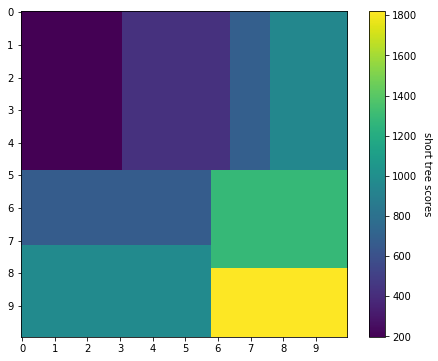

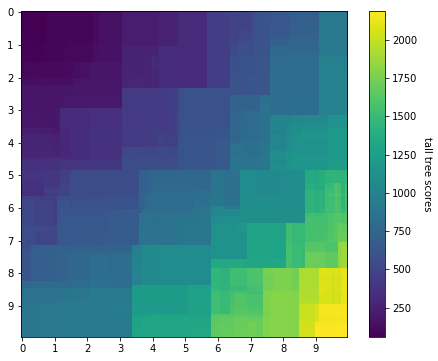

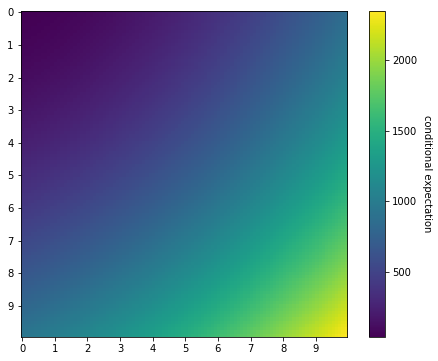

In [13]:
specified_poly_3rd_degree(np.array([7, 6, 2, 3, 7, 4, 2, 0, 7, 6]))

coeffs [ -2 -10   8   2  -7 -10  -3   1  -8   3]
avg 5.004639966112324 sqrd 32.84487427868578
y max 510.9553200429336 y min -1945.8594011694497 y mean -578.4666198818575


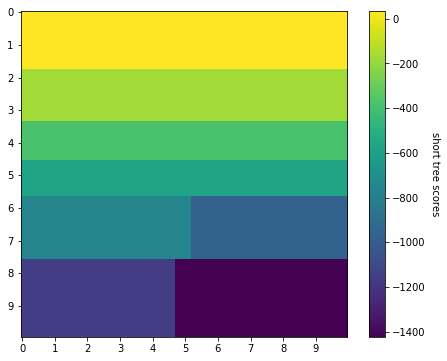

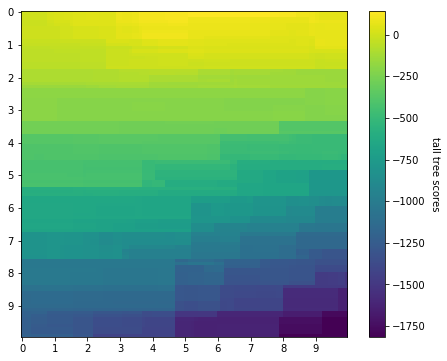

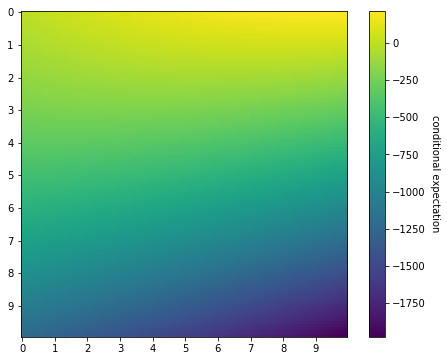

In [14]:
coeff_range = np.arange(-10, 10)
coeffs = np.random.choice(coeff_range, 10)
print("coeffs", coeffs)
specified_poly_3rd_degree(coeffs)

coeffs [ 6  0  3  4  0  0  7  4 -9  1]
avg 4.915303718093544 sqrd 32.329957370717565
y max 1250.7321674079403 y min 6.069861424779112 y mean 411.0735943451433


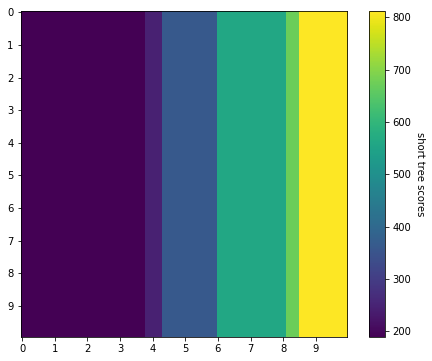

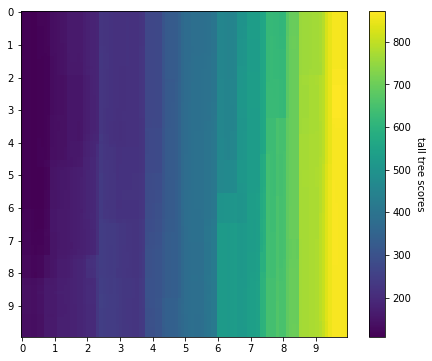

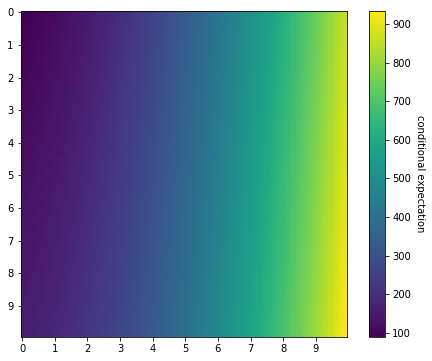

In [15]:
coeff_range = np.arange(-10, 10)
coeffs = np.random.choice(coeff_range, 10)
print("coeffs", coeffs)
specified_poly_3rd_degree(coeffs)

coeffs [ 6  2 -4 -5  0  9 -4  4  4  6]
avg 5.104426799285542 sqrd 34.31074360490756
y max 1485.3379687824904 y min 6.71905327365258 y mean 486.0128584043714


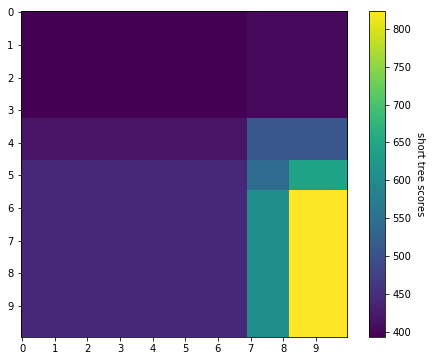

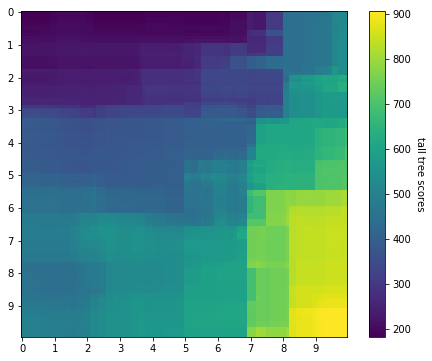

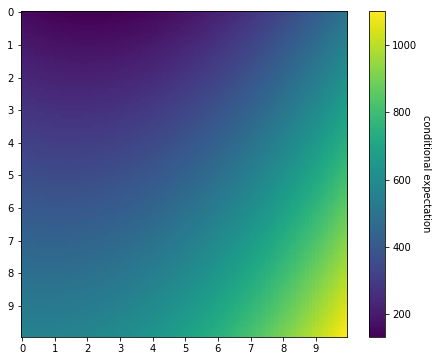

In [16]:
coeff_range = np.arange(-10, 10)
coeffs = np.random.choice(coeff_range, 10)
print("coeffs", coeffs)
specified_poly_3rd_degree(coeffs)

avg 5.0185375585903635 sqrd 33.345331599866014
y max 365.44746537868537 y min 0.6813121069573477 y mean 116.18186918306793


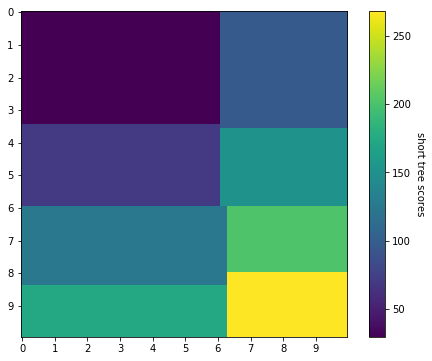

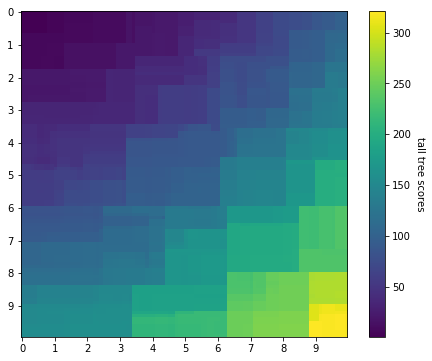

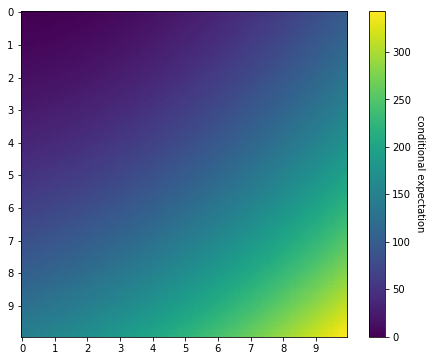

In [17]:
coeffs = np.array([1, 1, 0, 0, 1, 1, 0, 0, 0, 0])
specified_poly_3rd_degree(coeffs)

In [5]:
def many_ands(n, num_ands, x_axis):
    X = np.random.uniform(0, 10, (n, 2))
    y = np.zeros(n)
    exp = np.zeros(x_axis.shape)
    rules = []
    for i in range(num_ands):
        x1_bound, x2_bound = np.random.uniform(0, 10, (2))
        y += np.logical_and(X[:, 0] < x1_bound, X[:, 1] > x2_bound)
        exp += (x_axis < x1_bound) * (10 - x2_bound)/10.0
        rules.append((x1_bound, x2_bound))
    return X, y, exp, rules

In [6]:
def random_ands(num_ands):
    x_axis = np.arange(0, 10, .1)
    X, y, expectation, _ = many_ands(10000, num_ands, x_axis)
    short_tree = train_tree(X, y, depth_lim=3)
    tall_tree = train_tree(X, y)
    short_vals = traverse_all_paths(short_tree, X, y, [1, 0], continuous_y=True)
    tall_vals = traverse_all_paths(tall_tree, X, y, [1, 0], continuous_y=True)
    short_line = make_line(short_vals, (0, 10), .1, 0, 2)
    tall_line = make_line(tall_vals, (0, 10), .1, 0, 2)
    fig, ax = plt.subplots()
    fig.set_size_inches(8, 6, forward=True)
    plt.plot(x_axis, expectation, 'k--', c='r', label='E[f(x1, x2)|x1=x]')
    plt.plot(x_axis, short_line, 'k', c='b', label='short tree')
    plt.plot(x_axis, tall_line, 'k', c='g', label='tall tree')
    legend = ax.legend(loc='upper right', shadow=True, fontsize='x-large')
    plt.show()

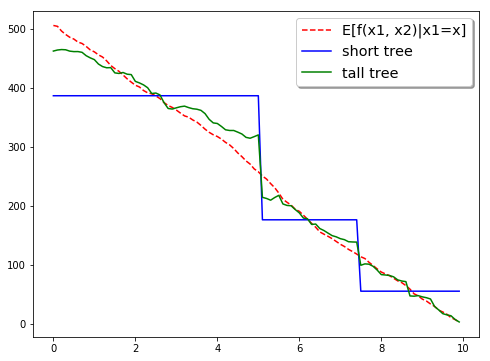

In [9]:
random_ands(1000)

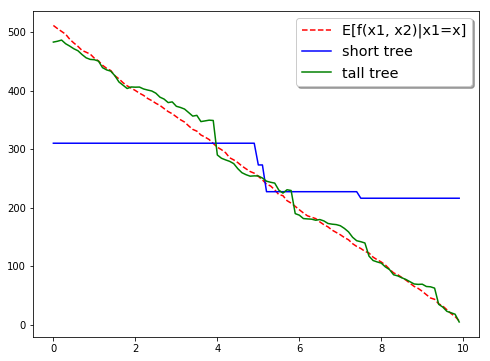

In [10]:
random_ands(1000)

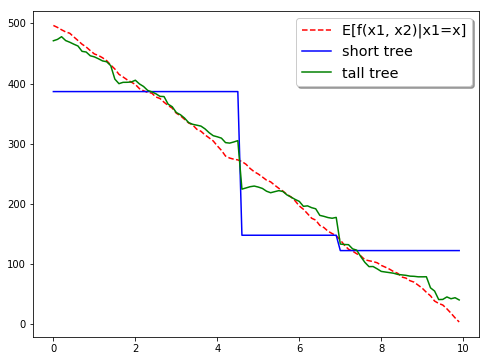

In [11]:
random_ands(1000)

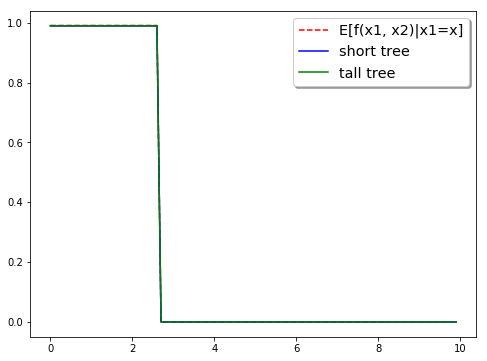

In [38]:
random_ands(1)

In [16]:
def output_grid(rules):
    x_axis = np.arange(0, 10, .1)
    vals = np.zeros((100, 100))
    for i in range(100):
        for j in range(100):
            x1 = x_axis[i]
            x2 = x_axis[j]
            for rule in rules:
                if x1 < rule[0] and x2 > rule[1]:
                    vals[j, i] += 1
    return vals

In [17]:
def random_ands_with_extra(num_ands, fn_x3):
    x_axis = np.arange(0, 10, .1)
    X, y, expectation, rules = many_ands(10000, num_ands, x_axis)
    x3 = np.random.uniform(0, 10, (10000,))
    X = np.hstack((X, np.reshape(x3, (-1, 1))))
    print("y shape", y.shape)
    print("x3 shape", x3.shape)
    y += fn_x3(x3)
    expectation += np.mean(fn_x3(x3))
    short_tree = train_tree(X, y, depth_lim=3)
    tall_tree = train_tree(X, y)
    short_vals = traverse_all_paths(short_tree, X, y, [1, 0, 0], continuous_y=True)
    tall_vals = traverse_all_paths(tall_tree, X, y, [1, 0, 0], continuous_y=True)
    short_line = make_line(short_vals, (0, 10), .1, 0, 3)
    tall_line = make_line(tall_vals, (0, 10), .1, 0, 3)
    fig, ax = plt.subplots()
    fig.set_size_inches(8, 6, forward=True)
    plt.plot(x_axis, expectation, 'k--', c='r', label='E[f(x1, x2)|x1=x]')
    plt.plot(x_axis, short_line, 'k', c='b', label='short tree')
    plt.plot(x_axis, tall_line, 'k', c='g', label='tall tree')
    legend = ax.legend(loc='upper right', shadow=True, fontsize='x-large')
    plt.show()
    vals = output_grid(rules)
    vals += np.mean(fn_x3(x3))
    short_vals2 = traverse_all_paths(short_tree, X, y, [1, 1, 0], continuous_y=True)
    tall_vals2 =  traverse_all_paths(tall_tree, X, y, [1, 1, 0], continuous_y=True)
    short_grid = make_grid(short_vals2, (0, 10), (0, 10), .1, 3)
    tall_grid = make_grid(tall_vals2, (0, 10), (0, 10), .1, 3)
    make_heatmap(short_grid, "short tree scores")
    make_heatmap(tall_grid, "tall tree scores")
    make_heatmap(vals, "conditional expectation")
    

y shape (10000,)
x3 shape (10000,)


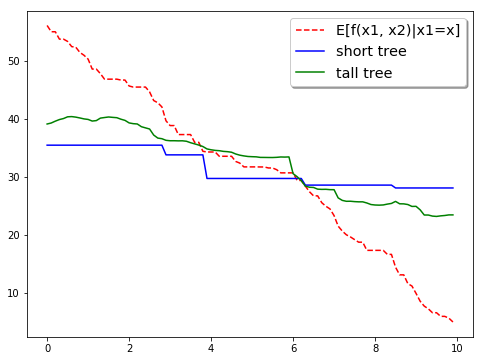

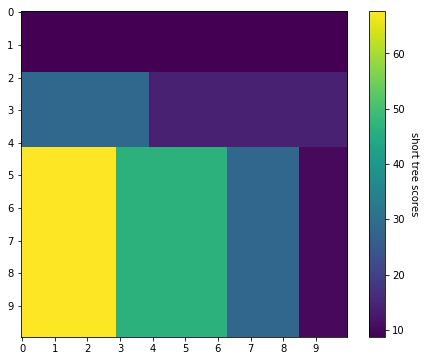

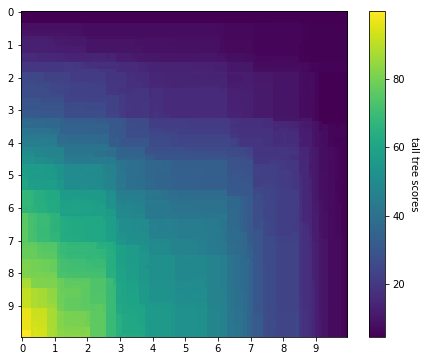

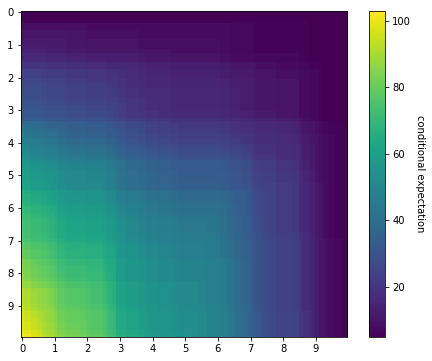

In [20]:
f = lambda x: x
random_ands_with_extra(100, f)

y shape (10000,)
x3 shape (10000,)


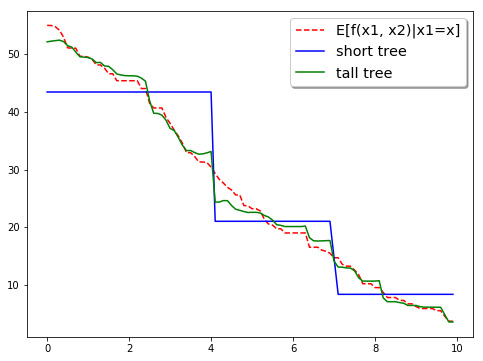

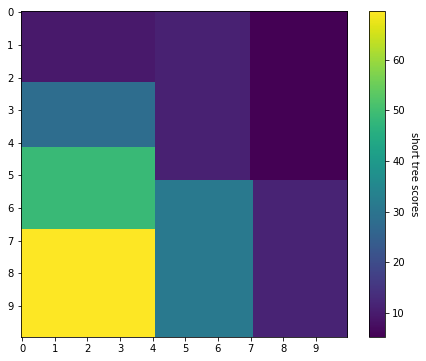

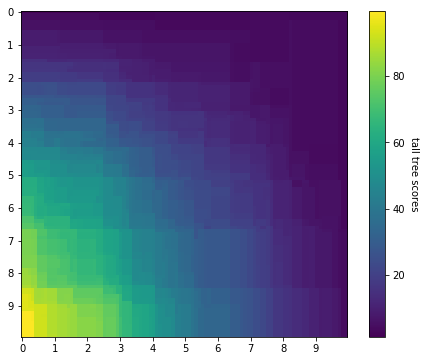

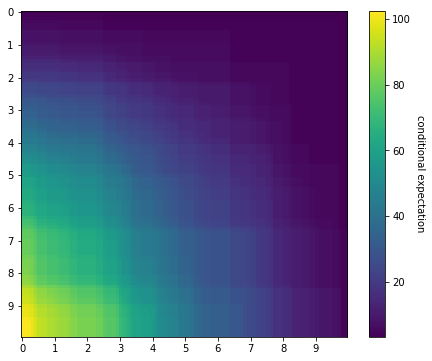

In [21]:
f = lambda x: 5 * (x > 3)
random_ands_with_extra(100, f)

y shape (10000,)
x3 shape (10000,)


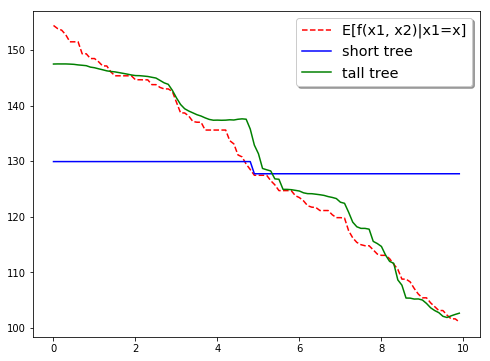

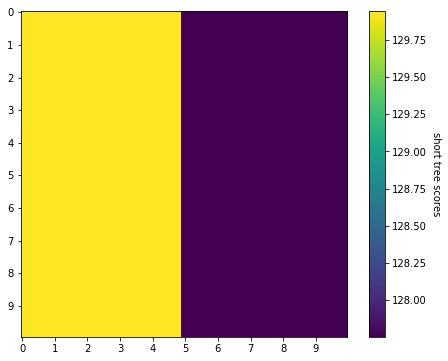

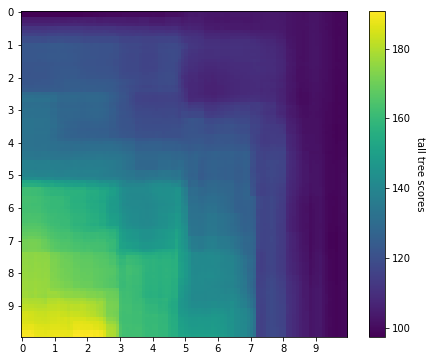

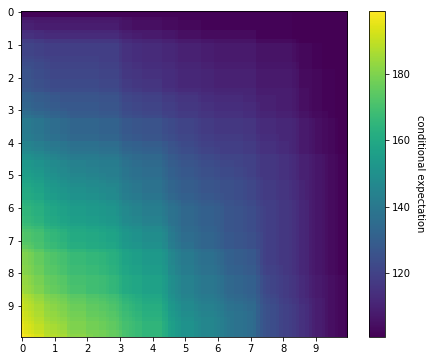

In [22]:
f = lambda x: 3 * x ** 2
random_ands_with_extra(100, f)